#Welcome to a Machine Learning Workshop for Astronomy!


---

June 12, 2024  
Hosts:  
Josh Taylor, Postdoctoral Fellow  
Stella Offner, Associate Professor  
The University of Texas at Austin, Department of Astronomy


---


## Workshop Goals

Today we will see how modern Machine Learning techniques can be used in Python to address common questions we have about (or ask of) data during the analysis stage of research projects. We will cover:
1. **Exploratory Data Analysis**, which is the process of quickly getting a high-level view of your data.
2. **Clustering**, which is a methodical way of partitioning a dataset into meaningful subgroups for further analysis.
3. **Classification**, which incorporates auxiliary information about our data in order to make predictions from it.

The first two tasks are examples of **Unsupervised Machine Learning**, which is the branch of ML concerned with making inferences about data *using only the data at hand*. The last is an example of **Supervised Machine Learning**, as it relies on auxiliary information (i.e., a "supervisor") to guide its inferences.


## Example Data: Gaia Spectroscopy

We have selected a real astronomy dataset to help showcase these ML techniques. These data come from the [Gaia Space Mission](https://www.esa.int/Science_Exploration/Space_Science/Gaia_overview), which is an ongoing in-depth survey of ~2 billion objects in the Milky Way. The [Gaia Data Archive](https://gea.esac.esa.int/archive/) housed by the European Space Agency contains many different types of observations made of Gaia's targets.

Today we will work with spectroscopy measurements of a small subset of Gaia targets. Our data are 343 flux measurements across a range of red & blue wavelengths for 3,388 different sources. We curated this subset from a much larger set of spectral data found [here](http://cdn.gea.esac.esa.int/Gaia/gdr3/Spectroscopy/xp_sampled_mean_spectrum/). We have normalized our data such that each source's spectra has unit Euclidean norm when considered as a vector.

Before we get started exploring Gaia, we need to ensure all Python packages required for further analysis are available. Run the following block, and ask us for help if any of the installation steps do not complete successfully.

In [ ]:
## Install additional Python packages
!pip install pandas numpy matplotlib seaborn scikit-learn yellowbrick

## Import required modules
# For data wrangling
import pandas as pd
import numpy as np
# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
# Dimensionality Reduction
from sklearn.manifold import TSNE
# Clustering
from sklearn.cluster import SpectralClustering
from yellowbrick.cluster import KElbowVisualizer
# Classification
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix, balanced_accuracy_score


# Set some default plotting parameters
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['figure.titleweight'] = 'bold'

# Exploratory Gaia Analysis

With Python setup complete, let's fetch our sample from its web source and do a quick inspection of its size & contents.

In [ ]:
## Read data from web
# Flux measurements at different wavelengths
flux = pd.read_csv('https://raw.githubusercontent.com/jt-ut/GaiaREU/main/data/GaiaREU_flux_trn.csv', header=None)
# The list of wavelengths [nanometers] at which flux was measured
wvl = pd.read_csv('https://raw.githubusercontent.com/jt-ut/GaiaREU/main/data/GaiaREU_wvl-nanometer.csv', header=None)[0]
flux.columns = wvl

# Inspect the downloaded data
print(flux.shape)
print(flux.iloc[0])

print(wvl.shape)
print(wvl)

(3388, 343)
0
330.000000     0.027306
332.105263     0.022852
334.210526     0.020077
336.315789     0.019672
338.421053     0.018942
                 ...   
1041.578947    0.045485
1043.684211    0.045064
1045.789474    0.046384
1047.894737    0.046835
1050.000000    0.049180
Name: 0, Length: 343, dtype: float64
(343,)
0       330.000000
1       332.105263
2       334.210526
3       336.315789
4       338.421053
          ...     
338    1041.578947
339    1043.684211
340    1045.789474
341    1047.894737
342    1050.000000
Name: 0, Length: 343, dtype: float64


Our flux data is arranged into a 3,388 row $\times$ 343 column ***data matrix***.

Each row represents an individual source (emitter of light) in the Gaia archive, and each column holds the flux measurements of that source at the 343 different wavelengths stored in the `wvl` vector, spanning the [330,1050] nanometer range. Our data is actually flux from a model fit (not the actual observation). You can read more about Gaia spectral processing [here](https://www.aanda.org/articles/aa/pdf/2023/06/aa43709-22.pdf).  

Almost all statistical and machine learning software packages expect a data matrix arranged as above, with ***observations*** contained in its rows and ***variable measurements*** in its columns.

Let's plot some of our spectra just to get an idea of what these 343-dimensional vectors can look like.

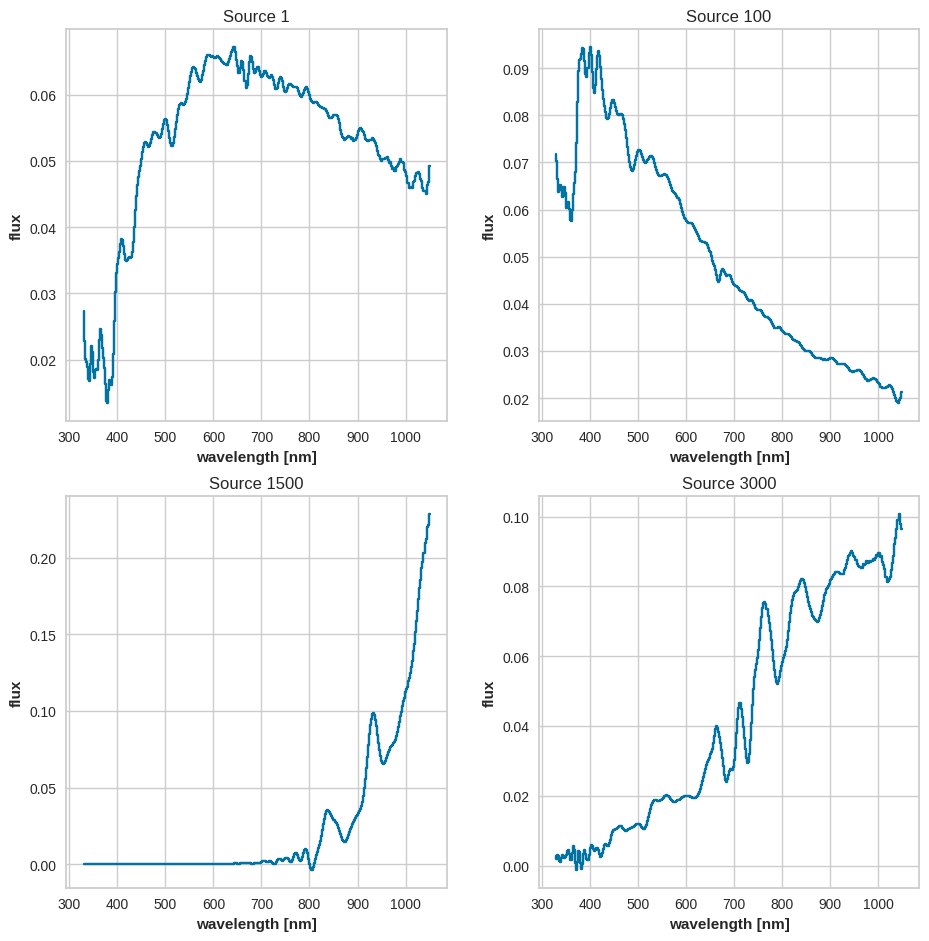

In [ ]:
# Plot a few spectra
plt.rcParams['figure.figsize'] = (6,6)
fig, axes = plt.subplots(2, 2)
fig.tight_layout()
sns.lineplot(x = 'wavelength [nm]', y = 'flux', data = pd.DataFrame({'wavelength [nm]': flux.columns, 'flux': flux.iloc[0]}), drawstyle='steps-pre', ax=axes[0,0]).set(title='Source 1')
sns.lineplot(x = 'wavelength [nm]', y = 'flux', data = pd.DataFrame({'wavelength [nm]': flux.columns, 'flux': flux.iloc[99]}), drawstyle='steps-pre', ax=axes[0,1]).set(title='Source 100')
sns.lineplot(x = 'wavelength [nm]', y = 'flux', data = pd.DataFrame({'wavelength [nm]': flux.columns, 'flux': flux.iloc[1499]}), drawstyle='steps-pre', ax=axes[1,0]).set(title='Source 1500')
sns.lineplot(x = 'wavelength [nm]', y = 'flux', data = pd.DataFrame({'wavelength [nm]': flux.columns, 'flux': flux.iloc[2999]}), drawstyle='steps-pre', ax=axes[1,1]).set(title='Source 3000')
fig.subplots_adjust(top=1.5, right=1.5);
plt.show()

What we have just done, plotting actual data vectors in their native space, is called ***data visualiation***. Visualizing your data is probably the easiest and most intuitive part of ***exploratory data analysis***, which allows us to get a crude idea of what's "going on" in our data. For example, our plots above indicate that the sources in our sample can have drastically different spectral profiles.



## Gaia Labels of Variable Star Type

Each source in our Gaia dataset has auxiliary information associated with it which we have ignored, until now. This additional info is a label indicating the type of star each source likely is (i.e., its *class*), and was generated by a [previous  analyis of the Gaia archive](https://arxiv.org/abs/2211.17238).

Let's download our data labels, called class labels, and inspect them. To start, we'd like to know what types of stars are known to exist in our dataset, and how many of each type we have.


In [ ]:
## Download Gaia labels
class_label = pd.read_csv('https://raw.githubusercontent.com/jt-ut/GaiaREU/main/data/GaiaREU_class-name_trn.csv', header=None)[0]
# Ensure we have a label for each source
print("%d labels for %d flux measurements!" % (class_label.shape[0], flux.shape[0]))

# Produce a frequency table, listing the unique class names and the number of sources belonging to each
class_label.value_counts(sort=True)

3388 labels for 3388 flux measurements!


0
YSO     1009
CEP      731
BCEP     533
SPB      474
EP       169
SYST     167
ACYG     139
WD        91
CV        62
AGN       13
Name: count, dtype: int64

We can see that every source is labeled by an acronym (e.g., YSO). Let's fetch a list of acronym descriptions to learn what these acronyms mean.

In [ ]:
## Download class descriptions
class_desc = pd.read_csv('https://raw.githubusercontent.com/jt-ut/GaiaREU/main/data/GaiaREU_class-description.csv', header=0)
class_desc

class_name                                  class_description
0        YSO                              Young Stellar Object.
1        CEP  Cepheid variable types: delta Cepheid, anomalo...
2       BCEP                         Beta Cephei type variable.
3        SPB                  Slowly Pulsating B-star variable.
4         EP                      Star with exoplanet transits.
5       SYST                           Symbiotic variable star.
6       ACYG                         Alpha Cygni-type variable.
7         WD  White Dwarf variable stars of types: ZZ Ceti (...
8         CV                              Cataclysmic variable.
9        AGN        Active Galactic Nuclei (including Quasars).

Given source labels, we might be interested in the group-wise mean flux for each class. Let's compute and plot those for comparison.

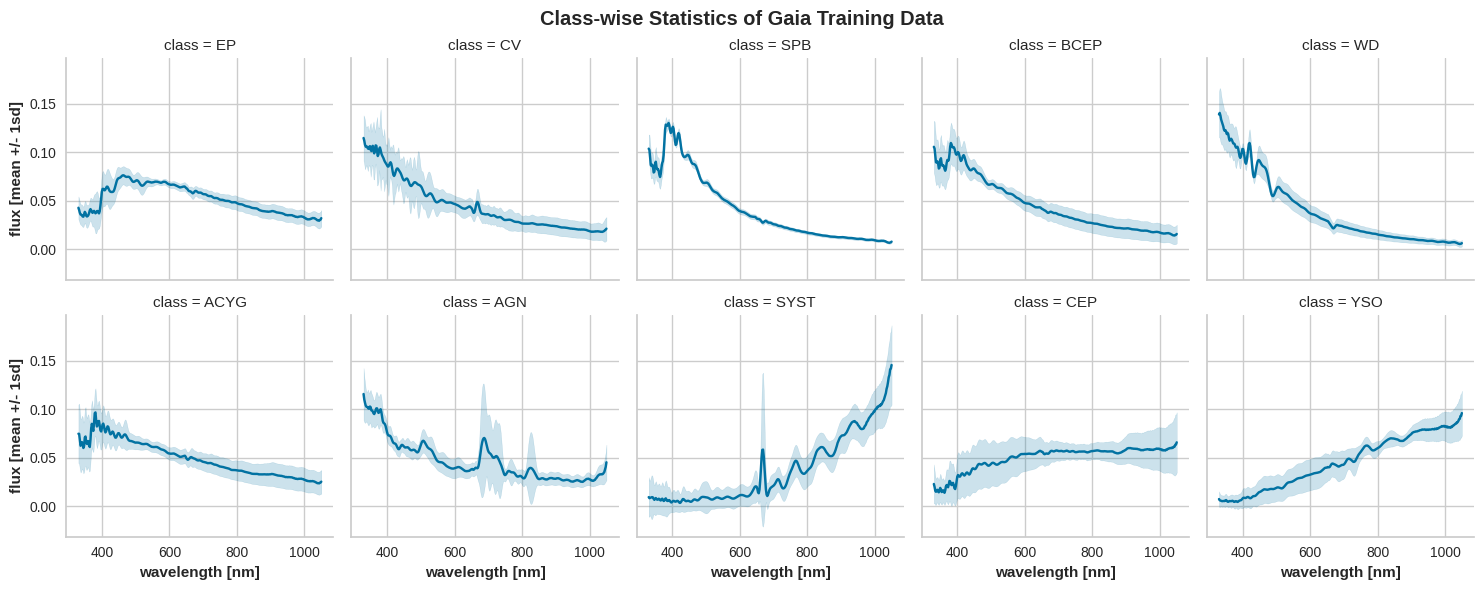

In [ ]:
## Compute & plot group means + stdevs

# Add the class information to our flux data frame, convert from wide to long format for plotting
class_stat_df = pd.melt(pd.concat([flux, pd.Series(class_label, name='class')], axis=1), id_vars='class', var_name="wvl", value_name='flux')
class_mean_df = class_stat_df.groupby(['class','wvl']).mean().reset_index()

# Seaborn Faceting makes group-wise summaries easy to visualize
plt_clstat = sns.FacetGrid(class_stat_df, col='class', col_wrap=5)
plt_clstat.map(sns.lineplot, "wvl", "flux", errorbar=('sd',1)).set(ylabel = 'flux [mean +/- 1sd]', xlabel='wavelength [nm]');
plt_clstat.fig.subplots_adjust(top=0.9);
plt_clstat.fig.suptitle('Class-wise Statistics of Gaia Training Data');



#Unsupervised Learning - Dimensionality Reduction

Since we can't realistically visualize the 343-dim spectra of all 3,000+ sources in our sample, we will instead build a *representation* of our data and visualize that. **Dimensionality Reduction** is the process of representing high-dimensional data in a lower dimensional space, usually 2-d or 3-d, for easy visualization. This is also called ***embedding*** our data into a lower dimensional space. It is one type of Unsupervised Machine Learning, which is the branch of ML that seeks to learn structure from our data ***without using any label information***.

There are many DR algorithms in statistics and machine learning. We introduce a few of the most commonly used below:

### PCA

Principal Components Analysis is an older technique from statistics that represents data as a linear combination of the eigenvectors of its covariance (correlation) matrix. DR is achieved by projecting data onto just a few (2 or 3) of these eigenvectors. While the more modern DR methods we discuss next are usually more expressive than PCA, it remains a common tool for data reduction because 1) there are no parameters for the user to worry about, 2) there are mathematical proofs of its optimality for variance explanation (no other DR technique has proofs of this nature) and 3) as a linear transformation of our data, it is very fast.


### t-SNE

t-distributed Stochastic Neighbor Embedding ([t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)) attempts to place points in low-dimensional space such that similarities among their $k$-nearest high-dimensional neighbors are preserved. $k$ is a user-supplied parameter that t-SNE calls *perplexity*. t-SNE defines point-wise similarity as a (Gaussian) function of distance, and minimizes [Kullback-Leibler Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) to bring low-dim point similarites in line with their high-dim counterparts.

### UMAP

Uniform Manifold Approximation & Projection ([UMAP](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)) is built upon the same idea as t-SNE, except it defines its high-dim and low-dim similarities differently (but still as a function of distance), and then attempts to find low-dim points which minimize the [Cross-Entropy](https://en.wikipedia.org/wiki/Cross_entropy) between themselves and their high-dim counterparts. UMAP also needs a user-supplied parameter it calls *n_neighbors*, which controls how many point-wise similarities should be preserved in low-dim.

**There are many other Dimensionality-Reduction techniques!** (e.g., Self-Organizing Maps, Local Linear Embedding, Spectral Embedding, Sammon's Mapping, ... this list is long!). For now, don't worry about the details of how they work. Just remember that they all try to embed points such that their proximity in low-$d$ somehow represents a similarity of the corresponding high-$d$ points.  

Let's perform Dimensionality Reduction on our data with t-SNE and see how each of the above algorithms places points in the 2-d plane. t-SNE requires us to specify its *perplexity* parameter before running (roughly, the number of high-$d$ neighbors that t-SNE attempts to align in 2-$d$ space). The default perplexity in scikit-learn's t-SNE function is 30, which we will use, but pick a value lower than 30 and higher than 30 to compare.

In [ ]:
## t-SNE, using default perplexity = 30
T30 = TSNE(perplexity=30.0, n_components=2, random_state = 123, verbose=1, n_jobs=2, init='pca').fit_transform(flux)
T30 = pd.DataFrame(T30, columns = ['x','y'])

## Set a "lo" (<30) and "hi" (>30) value to see how t-SNE changes with different perplexities
perp_lo = ?? # something lower then 30
perp_hi = ?? # something higher than 30

## Re-run t-SNE with these different values
Tlo = TSNE(perplexity=perp_lo, n_components=2, random_state = 123, verbose=1, n_jobs=2, init='pca').fit_transform(flux)
Tlo = pd.DataFrame(Tlo, columns = ['x','y'])

Thi = TSNE(perplexity=perp_hi, n_components=2, random_state = 123, verbose=1, n_jobs=2, init='pca').fit_transform(flux)
Thi = pd.DataFrame(Thi, columns = ['x','y'])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3388 samples in 0.009s...
[t-SNE] Computed neighbors for 3388 samples in 0.401s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3388
[t-SNE] Computed conditional probabilities for sample 2000 / 3388
[t-SNE] Computed conditional probabilities for sample 3000 / 3388
[t-SNE] Computed conditional probabilities for sample 3388 / 3388
[t-SNE] Mean sigma: 0.023655
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.731930
[t-SNE] KL divergence after 1000 iterations: 0.722527
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 3388 samples in 0.004s...
[t-SNE] Computed neighbors for 3388 samples in 0.277s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3388
[t-SNE] Computed conditional probabilities for sample 2000 / 3388
[t-SNE] Computed conditional probabilities for sample 3000 / 3388
[t-SNE] Computed conditional probabilities for sample 3388 / 3388
[t-SNE] Mean sigma: 0.012390


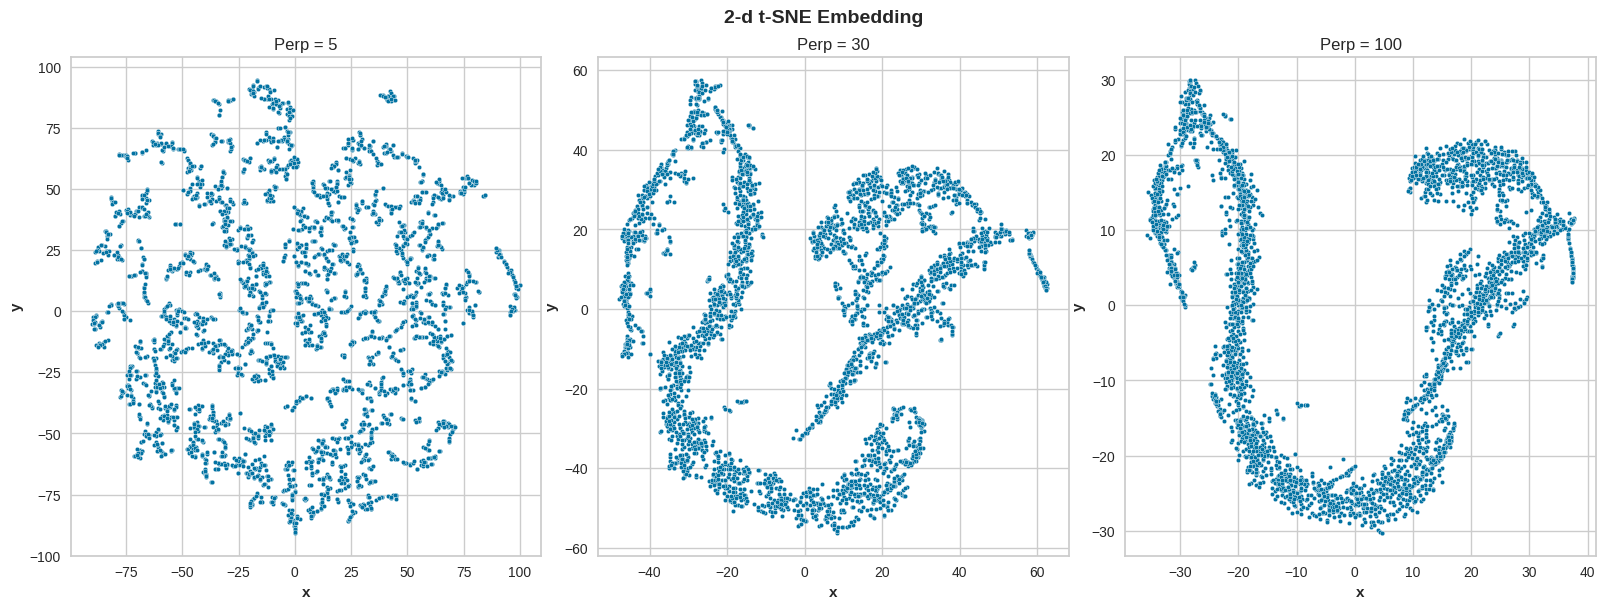

In [ ]:
## Visualize the PCA, t-SNE, and UMAP representations of our spectra
plt.rcParams['figure.figsize'] = (16,6)

fig, axes = plt.subplots(1, 3)
fig.tight_layout()
fig.suptitle("2-d t-SNE Embedding", fontsize=14)
sns.scatterplot(x='x', y='y', data = Tlo, s=10, ax=axes[0]).set(title="Perp = %d" % perp_lo)
sns.scatterplot(x='x', y='y', data = T30, s=10, ax=axes[1]).set(title="Perp = 30")
sns.scatterplot(x='x', y='y', data = Thi, s=10, ax=axes[2]).set(title="Perp = %d" % perp_hi)
fig.subplots_adjust(top=0.90)
plt.show()

**Which of the above embeddings do you think is "best"?**

This is a bit of a trick question! There are [many purely quantitative ways](https://www.mdpi.com/2504-4990/5/3/56) to assess the quality of dimensionality reduction. These methods generally report how "faithful" the embedding is with respect high-$d$ nearest-neighbor relationships -- e.g., whether two points that are next-door neighbors in the embedding are also next-door neighbors in high-$d$. The downside is that the quality assessment methods rarely agree amongst themselves about which embedding is "best".

If you know something about your data it is usually better to see how organized an embedding is with respect to a known quantity of interest. Since our data our spectra, we might be interested in the spectral peak (highest measured flux in the signal), the location of this peak, and some measure of peak "width" (spread).

Let's compute these values and project them onto our t-SNE embeddings to see whether t-SNE has produced any (spectrally) meaningful organization.


<ipython-input-17-bbfeab8be16a>:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm)


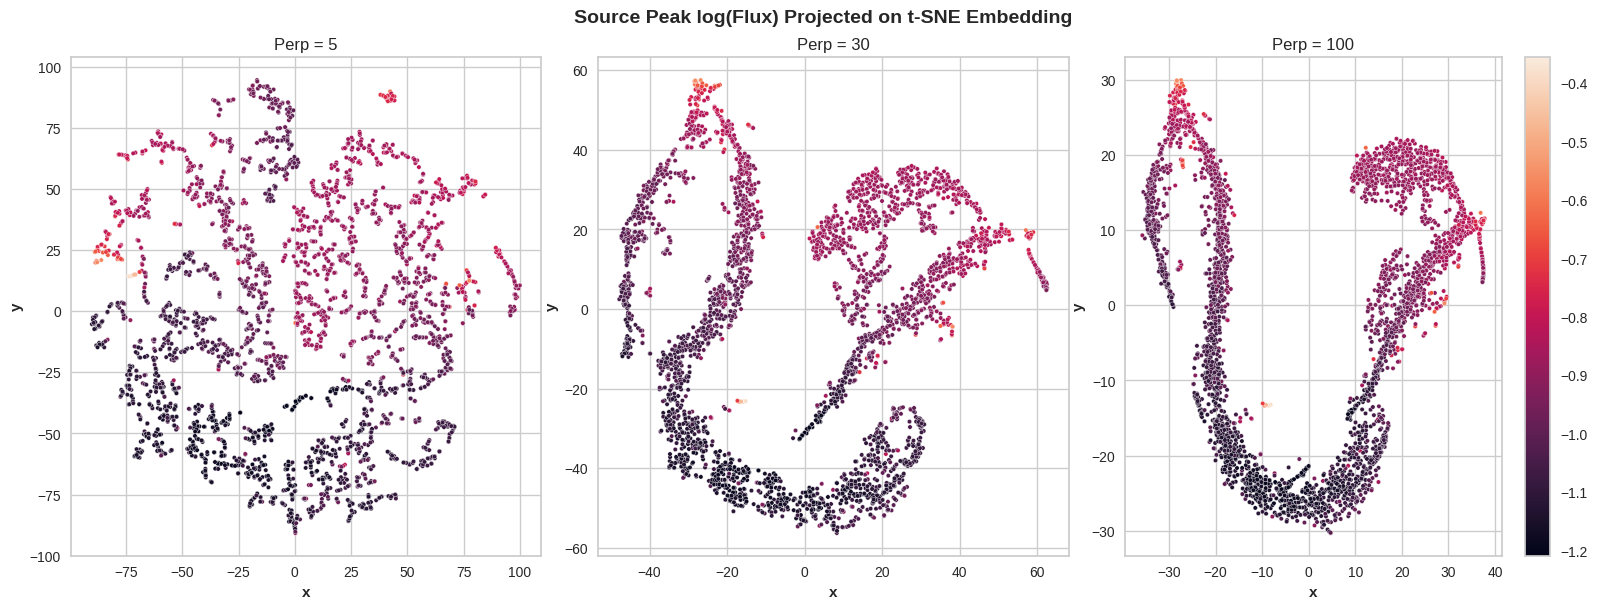

In [ ]:
## Compute max(Flux) in each source's spectrum
PeakFlux = np.log10(flux.max(axis=1))

## Plot this value on the t-SNE Embedding
norm = plt.Normalize(PeakFlux.min(), PeakFlux.max())
sm = plt.cm.ScalarMappable(cmap="rocket", norm=norm)

fig, axes = plt.subplots(1, 3)
fig.tight_layout()
fig.suptitle("Source Peak log(Flux) Projected on t-SNE Embedding", fontsize=14);
sns.scatterplot(x='x', y='y', data = Tlo, s=10, ax=axes[0], hue=PeakFlux, palette="rocket", legend=False).set(title="Perp = %d" % perp_lo);
sns.scatterplot(x='x', y='y', data = T30, s=10, ax=axes[1], hue=PeakFlux, palette="rocket", legend=False).set(title="Perp = 30");
sns.scatterplot(x='x', y='y', data = Thi, s=10, ax=axes[2], hue=PeakFlux, palette="rocket", legend=False).set(title="Perp = %d" % perp_hi);

fig.colorbar(sm);
fig.subplots_adjust(top=0.90);
plt.show()

<ipython-input-18-2626fa698d8f>:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm)


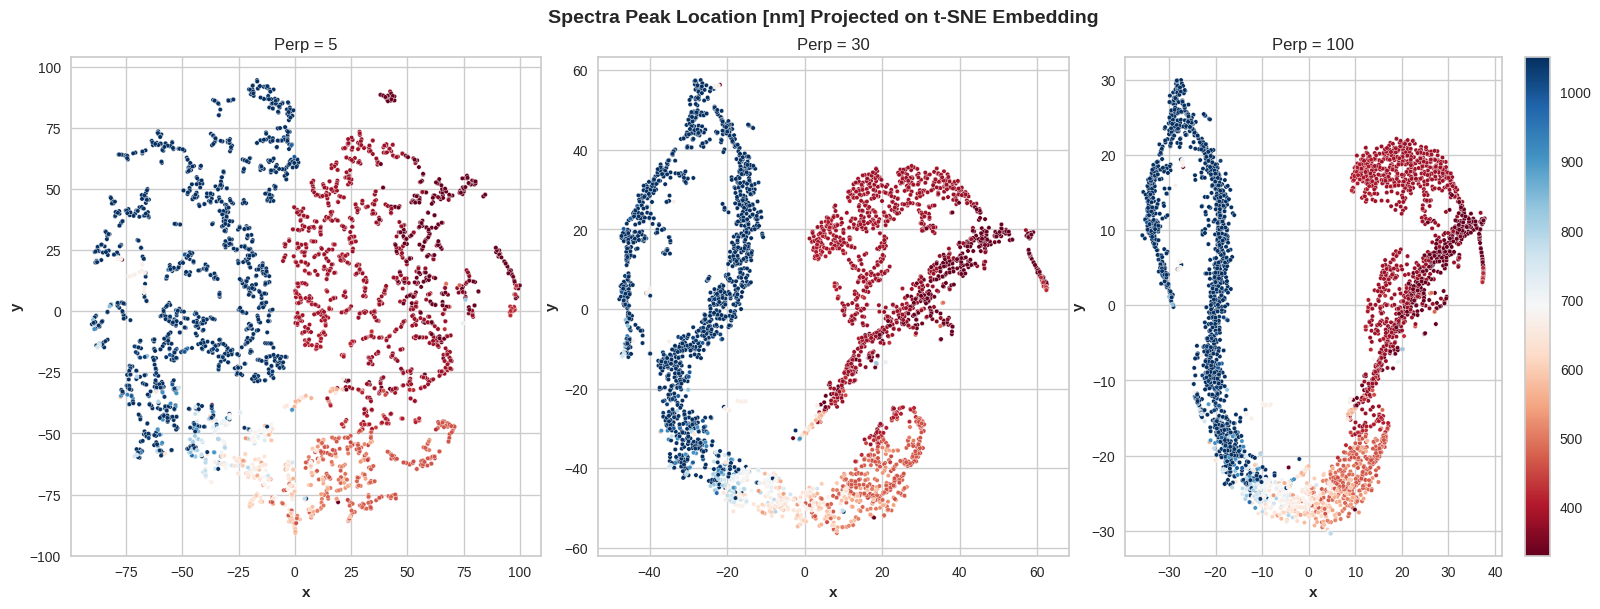

In [ ]:
## Compute location of peak in each source's spectrum
PeakWvl = flux.idxmax(axis=1)

## Plot this value on the t-SNE Embedding
norm = plt.Normalize(PeakWvl.min(), PeakWvl.max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)

fig, axes = plt.subplots(1, 3)
fig.tight_layout()
fig.suptitle("Spectra Peak Location [nm] Projected on t-SNE Embedding", fontsize=14);
sns.scatterplot(x='x', y='y', data = Tlo, s=10, ax=axes[0], hue=PeakWvl, palette="RdBu", legend=False).set(title="Perp = %d" % perp_lo);
sns.scatterplot(x='x', y='y', data = T30, s=10, ax=axes[1], hue=PeakWvl, palette="RdBu", legend=False).set(title="Perp = 30");
sns.scatterplot(x='x', y='y', data = Thi, s=10, ax=axes[2], hue=PeakWvl, palette="RdBu", legend=False).set(title="Perp = %d" % perp_hi);

fig.colorbar(sm);
fig.subplots_adjust(top=0.90)
plt.show()

<ipython-input-19-e386662b2ec3>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.sum(f * (w - w.max())**2) / np.sum(f))
<ipython-input-19-e386662b2ec3>:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm)


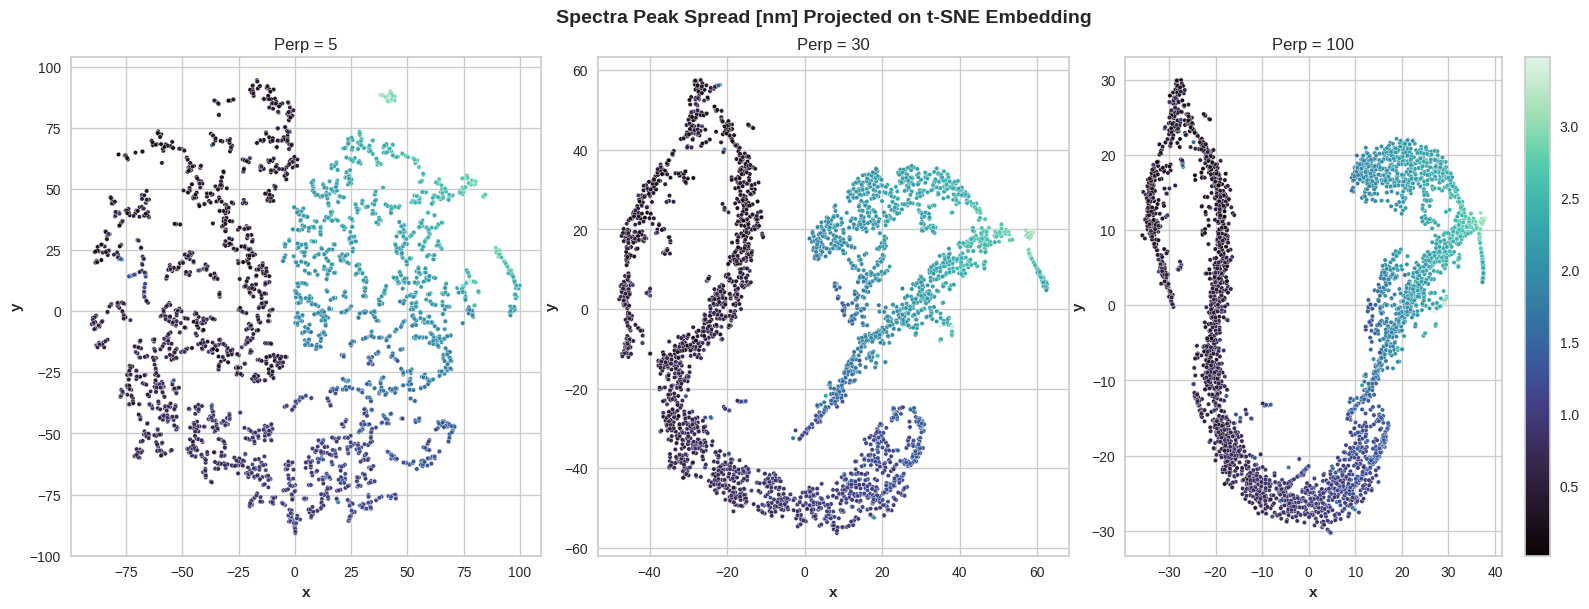

In [ ]:
## Define a function to compute a proxy quantity for spectral peak width
def spectrum_peak_spread(f, w):
  # f = vector of fluxes, w = wavelengths corresponding to each flux
  return np.sqrt(np.sum(f * (w - w.max())**2) / np.sum(f))

## Apply the above function to compute peak width for each source
PeakSigma = flux.apply(spectrum_peak_spread, axis=1, w=wvl)

## Plot this value on the t-SNE Embedding
norm = plt.Normalize(PeakSigma.min(), PeakSigma.max())
sm = plt.cm.ScalarMappable(cmap="mako", norm=norm)

fig, axes = plt.subplots(1, 3)
fig.tight_layout()
fig.suptitle("Spectra Peak Spread [nm] Projected on t-SNE Embedding", fontsize=14);
sns.scatterplot(x='x', y='y', data = Tlo, s=10, ax=axes[0], hue=PeakSigma, palette="mako", legend=False).set(title="Perp = %d" % perp_lo);
sns.scatterplot(x='x', y='y', data = T30, s=10, ax=axes[1], hue=PeakSigma, palette="mako", legend=False).set(title="Perp = 30");
sns.scatterplot(x='x', y='y', data = Thi, s=10, ax=axes[2], hue=PeakSigma, palette="mako", legend=False).set(title="Perp = %d" % perp_hi);

fig.colorbar(sm);
fig.subplots_adjust(top=0.90)
plt.show()

**Based on these representations, does our data appear to be completely random, or does it have any meaningful structure?**

**What has t-SNE learned about our data?**

Even though t-SNE did not see or use our data labels, let's see whether they are organized in the embedding. If you have labels, projecting them to an embedding provides a good sanity-check for determining embedding quality.

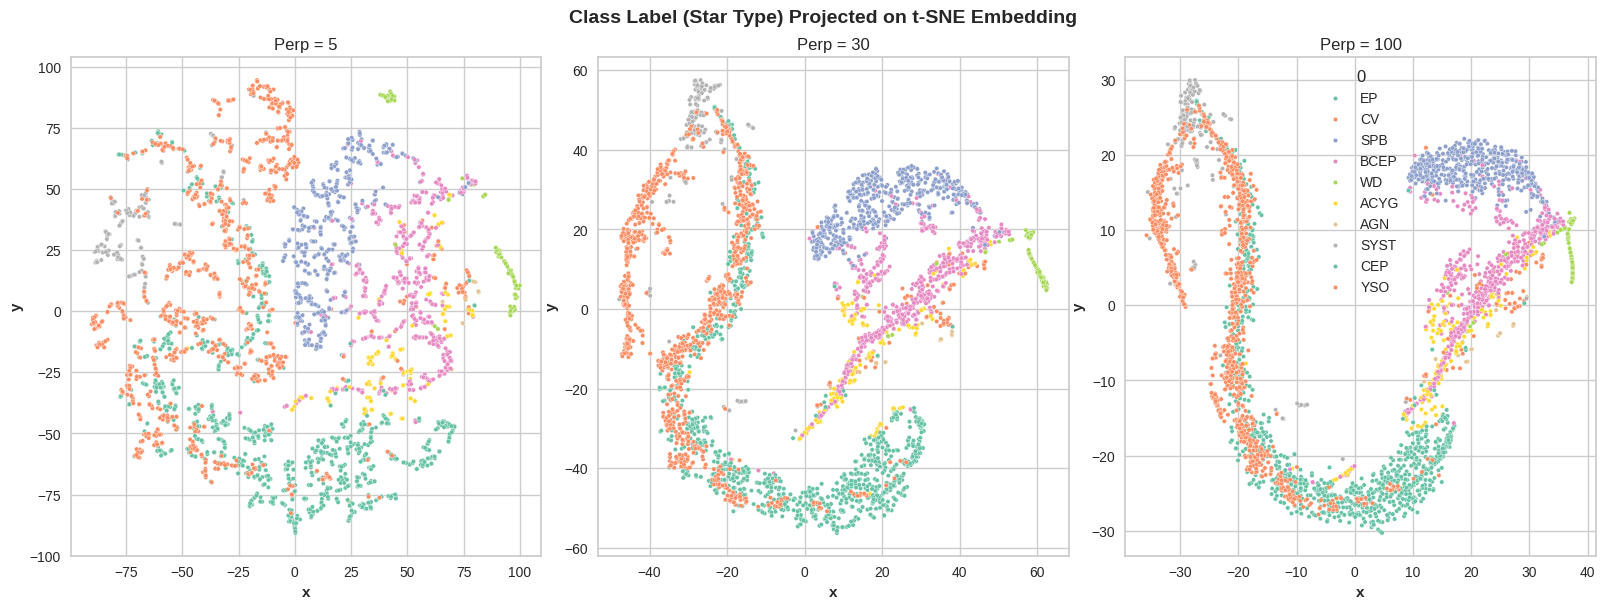

In [ ]:
## Visiualize the class labels of each source on the embeddings
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
fig.suptitle("Class Label (Star Type) Projected on t-SNE Embedding", fontsize=14)
sns.scatterplot(x='x', y='y', data = Tlo, s=10, ax=axes[0], hue=class_label, palette="Set2", legend=False).set(title="Perp = %d" % perp_lo);
sns.scatterplot(x='x', y='y', data = T30, s=10, ax=axes[1], hue=class_label, palette="Set2", legend=False).set(title="Perp = 30");
sns.scatterplot(x='x', y='y', data = Thi, s=10, ax=axes[2], hue=class_label, palette="Set2", legend=True).set(title="Perp = %d" % perp_hi);

fig.subplots_adjust(top=0.90)
plt.show()

**After visualizing these quantities of interest, Which of the 3 t-SNE embeddings do you prefer, and why?**

Store your favorite embedding in the variable TBest below:

In [ ]:
## Uncomment the line corresponding to your favorite embedding, and run this cell.
## Later, we will use your favorite embedding to visualize more information learned from Gaia
#TBest = Tlo
#TBest = T30
#TBest = Thi

# Unsupervised Learning - Clustering

The most common technique in Unsupervised Machine Learning is called [clustering](https://en.wikipedia.org/wiki/Cluster_analysis), which partitions a dataset into $K$ groups of "similar items." This is a more formal process that mimics the visual search for structure we attempted above.

As you might suspect, there is no universally applicable definition of what it means for two points to be "similar". Because each clustering algorithm differs in how they define point-wise similarities, there is also no universally "best" clustering algorithm. Just like in DR analysis, we usually have to try several different algorithms with different parameterizations, and use external knowledge or assumptions about the domain which generated our data (here, astronomy) to pick a good clustering.  

## Spectral Clustering

Although there are [many](https://scikit-learn.org/stable/modules/clustering.html) algorithms to choose from, we will partition Gaia using  [Spectral Clustering](https://en.wikipedia.org/wiki/Spectral_clustering), which groups data points based on their similarity in a highly customized space that it defines internally. For now, don't worry about the details of how Spectral Clustering identifies clusters.

Spectral clustering only has one parameter, $K$, which tells the algorithm how many groups to split the data into. To get a feel for how this works, let's ask Spectral Clustering to partition our data into 10 groups, because we know from above there are 10 distinct class labels, and see how those groups are displayed on the embedding you selected above.  

The colors on the resulting plot correspond to each points's cluster label.

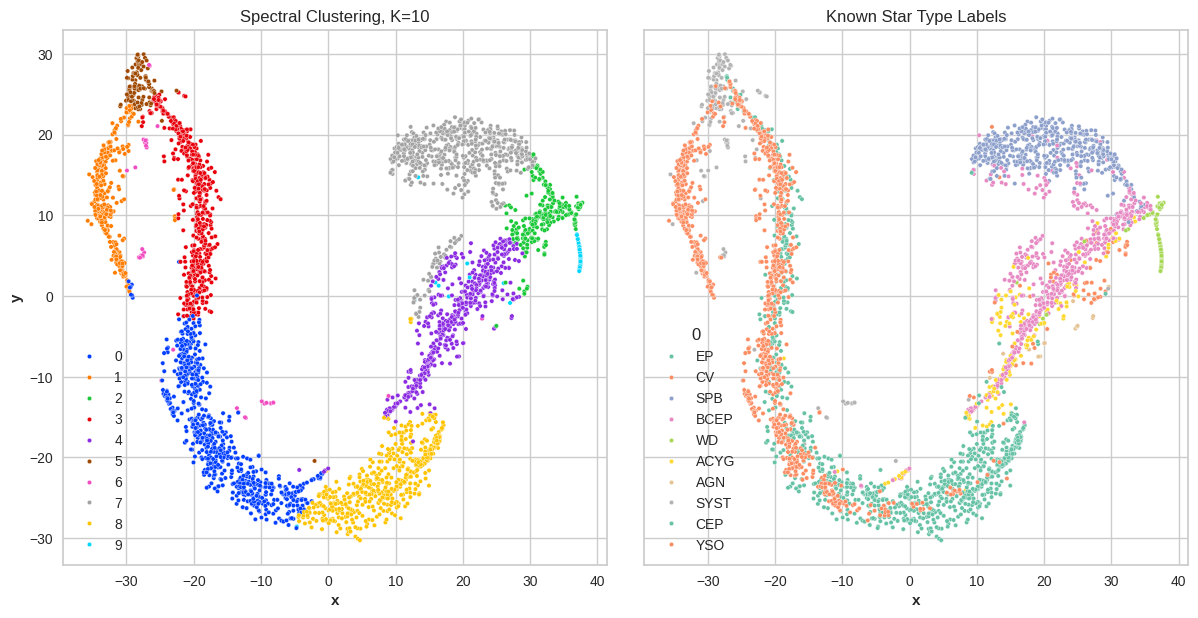

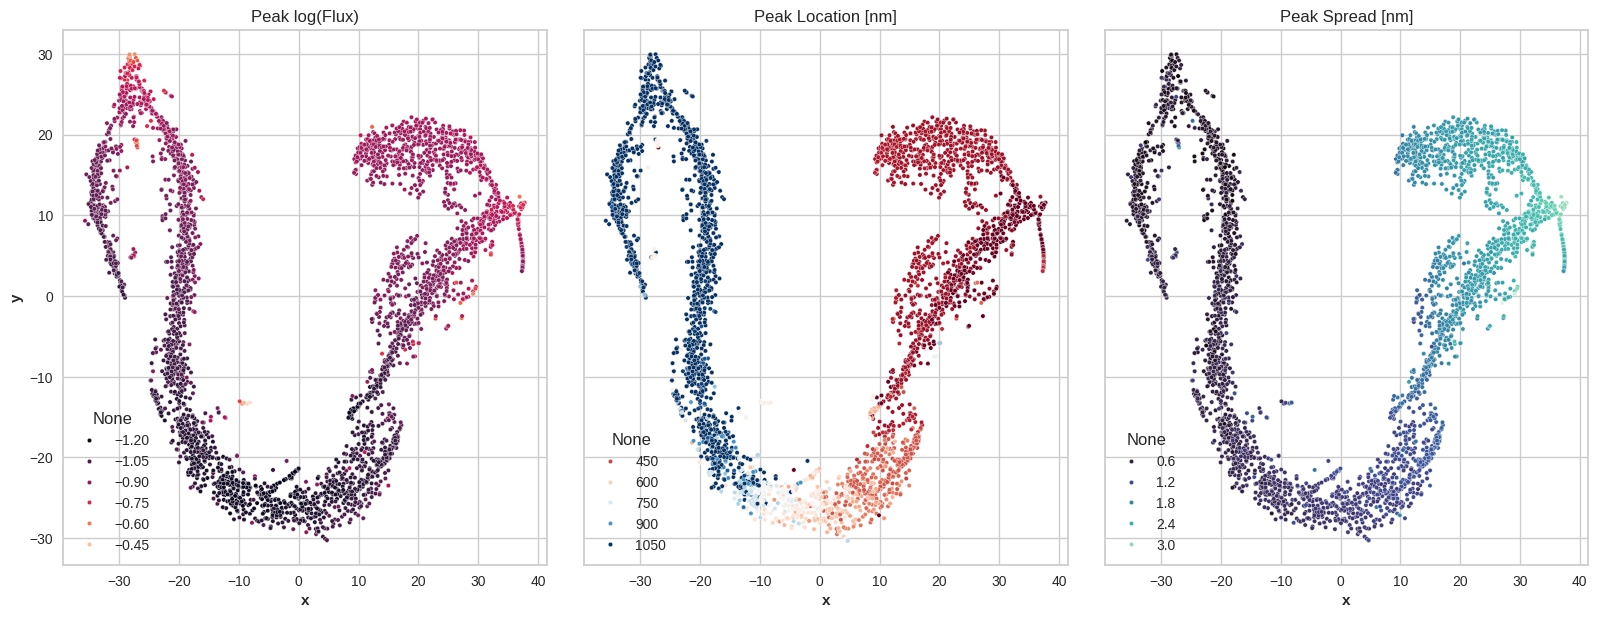

In [ ]:
## Run Spectral Clustering with K=10 groups
## The result is an integer vector, length = nrows(flux), which contains the cluster label for each Gaia source
clus_SPECTRAL = SpectralClustering(n_clusters=10, assign_labels='discretize', random_state=0).fit(flux).labels_

# Plot the clusters labels identified by Spectral Clustering, alongside our known class labels for comparison
plt.rcParams['figure.figsize'] = (12,6)
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.tight_layout()
sns.scatterplot(x='x', y='y', data = TBest, s=10, ax=axes[0], hue=clus_SPECTRAL, palette="bright", legend=True).set(title='Spectral Clustering, K=10');
sns.scatterplot(x='x', y='y', data = TBest, s=10, ax=axes[1], hue=class_label, palette="Set2", legend=True).set(title="Known Star Type Labels")
plt.show()

# Replot the quantites of interest in our spectra, to get an idea what the identified clusters might mean
plt.rcParams['figure.figsize'] = (16,6)
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
fig.tight_layout()
sns.scatterplot(x='x', y='y', data = TBest, s=10, ax=axes[0], hue=PeakFlux, palette="rocket").set(title="Peak log(Flux)")
sns.scatterplot(x='x', y='y', data = TBest, s=10, ax=axes[1], hue=PeakWvl, palette="RdBu").set(title="Peak Location [nm]")
sns.scatterplot(x='x', y='y', data = TBest, s=10, ax=axes[2], hue=PeakSigma, palette="mako").set(title="Peak Spread [nm]")
plt.show()

In the above, we *clustered* the data in high-d space, and visualized the results by *projecting* the cluster labels onto our low-dim embedding.

**Do the clusters appear organized on the embedding, with respect to the known class labels?**

**Do the clusters appear organized with respect to the quantities of interest we computed above?**

**Overall, Does the partition found by Spectral Clustering appear to agree with the structure you see in the embedding?**



## Selecting the Number Clusters

In the above we grouped Gaia point sources into 10 clusters because we know there are 10 distinct class labels. What would you do if you didn't know this information beforehand?

This is a challenging task as we usually do not know how many meaningful groups may exist in our data. So how do we decide which $K$ to specify for Spectral Clustering?

The typical way of solving this problem is to run the clustering algorithm several times with different values of $K$ and measure the quality of the resulting clusters as reported by various ***clustering performance metrics***. There are [many](https://scikit-learn.org/stable/modules/clustering#clustering-performance-evaluation) such metrics which are inspired by an intuitive notion of what a cluster is: good clusters are generally ***compact***, meaning the points within a cluster are close to each other, and ***well-separated***, meaning the individual clusters are far apart from each other.

We will run Spectral Clustering for different $K$ in the range $(2,20)$, and assess the resulting clusterings using three different metrics:
* Distortion (measures cluster compactness, low distortion is better)
* Silhouette Score (measures tradeoff between compactness & separation, high Silhouette is better)
* Calinski-Harabasz Score (measures tradeoff between compactness & separation, high CH is better)

We *could* do this exercise manually using functions from scikit-learn, but there is a more automated way of producing & visualizing this information available in Python's yellowbrick package. Below, we produce plots of Distortion/Silhouette/CH score vs. $K$, and inspect the curves to find the $K$ which optimizes each score.

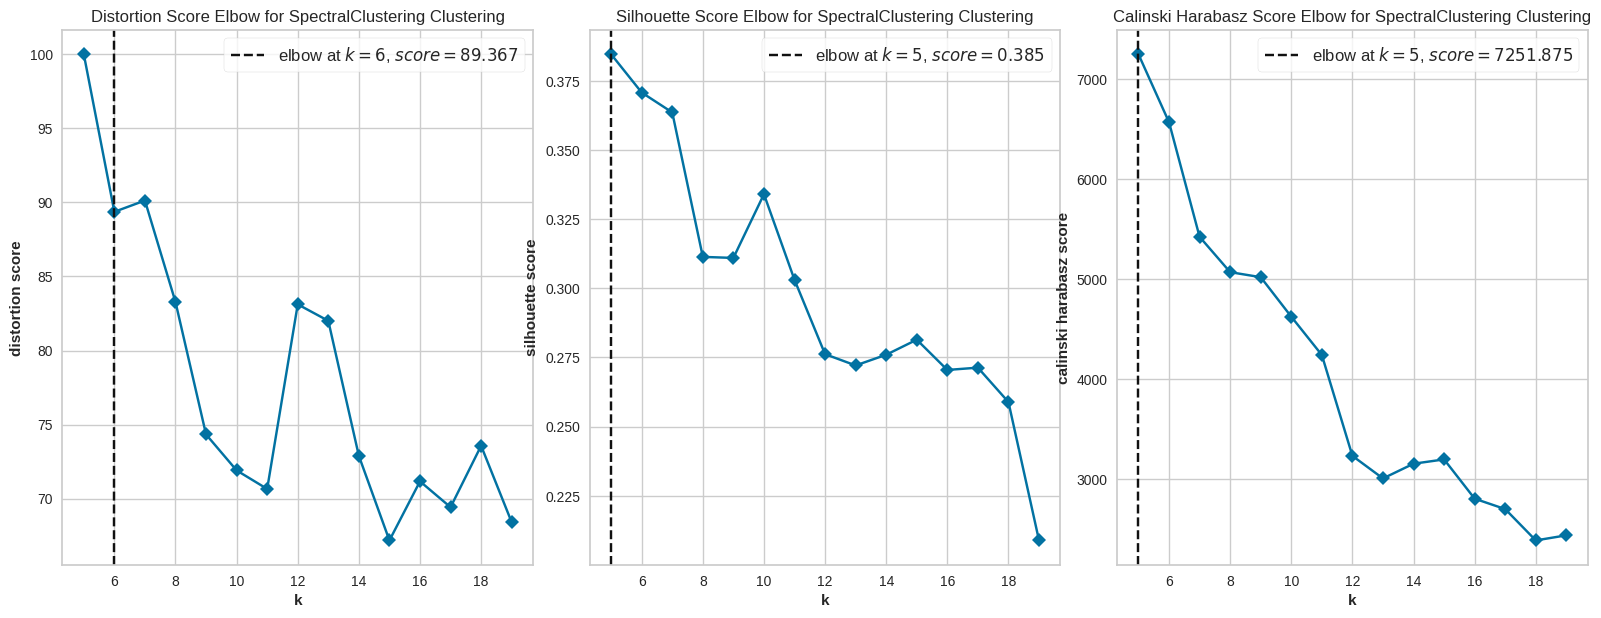

In [ ]:
## Spectral Clustering assesses over a range of different K values
## First, setup a spectral clustering object as the cluster algorithm, specify the range of different K we will consider
model = SpectralClustering(assign_labels='discretize', random_state=0)
Krange = (5,20)
# Axes to plot different visualizations
plt.rcParams['figure.figsize'] = (16,6)
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
# Measure by distortion
kselect_dist = KElbowVisualizer(model, k=Krange, metric = 'distortion', timings=False, ax=axes[0])
kselect_dist.fit(flux) # Fit data to visualizer
kselect_dist.finalize()
# Measure by Silhouette
kselect_sil = KElbowVisualizer(model, k=Krange, metric = 'silhouette', timings=False, ax=axes[1])
kselect_sil.fit(flux) # Fit data to visualizer
kselect_sil.finalize()
# Measure by Calinski-Harabasz
kselect_ch = KElbowVisualizer(model, k=Krange, metric = 'calinski_harabasz', timings=False, ax=axes[2])
kselect_ch.fit(flux) # Fit data to visualizer
kselect_ch.finalize()

You should see that not all curves have a clearly defined optimal $K$. Selecting the "right" number of clusters in a dataset is difficult, and there are often valid arguments to be made supporting *several* candidate $K$s.

Let's study the curves and decide whether $K=10$ is a good number of clusters for Gaia, or whether another value might be better. Remember: lower distortion is better, and higher Silhouette & Calinski-Harabasz are better.

Based on our discussion, decide how many clusters you believe may exist in Gaia, and store that number of the `Kdesired` variable below. We will re-cluster Gaia using your favorite $K$, and visualize the clusters.

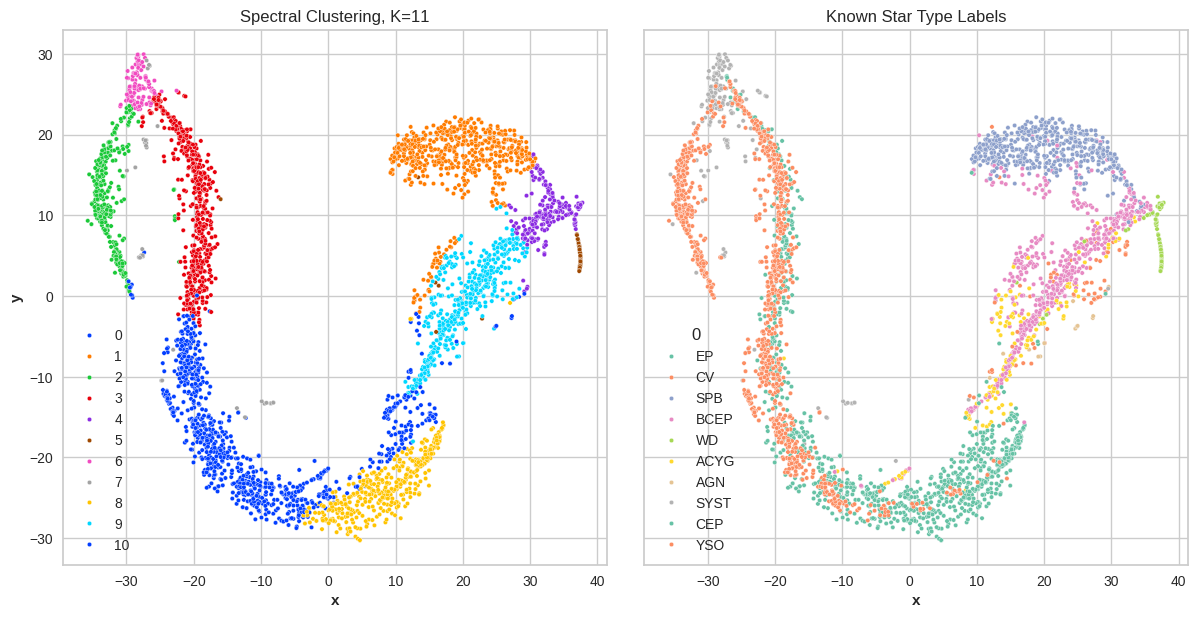

In [ ]:
## Set the number of clusters you inferred from the above knee plots in the Kdesired variable
myK = ?? # replace ?? with your preferred number of clusters

# Run K-Means Clustering to partition Gaia into the desired number of clusters, view alongside known labels
clus_myK = SpectralClustering(n_clusters=myK, assign_labels='discretize', random_state=0).fit(flux).labels_

plt.rcParams['figure.figsize'] = (12,6)
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.tight_layout()
sns.scatterplot(x='x', y='y', data = TBest, s=10, ax=axes[0], hue=clus_myK, palette="bright", legend=True).set(title='Spectral Clustering, K=%d' % myK);
sns.scatterplot(x='x', y='y', data = TBest, s=10, ax=axes[1], hue=class_label, palette="Set2", legend=True).set(title="Known Star Type Labels")
plt.show()

Do any of our discovered clusters seem to align with known variable star types? To see, we can compute the mean flux by cluster, and compare to the mean flux by star type.

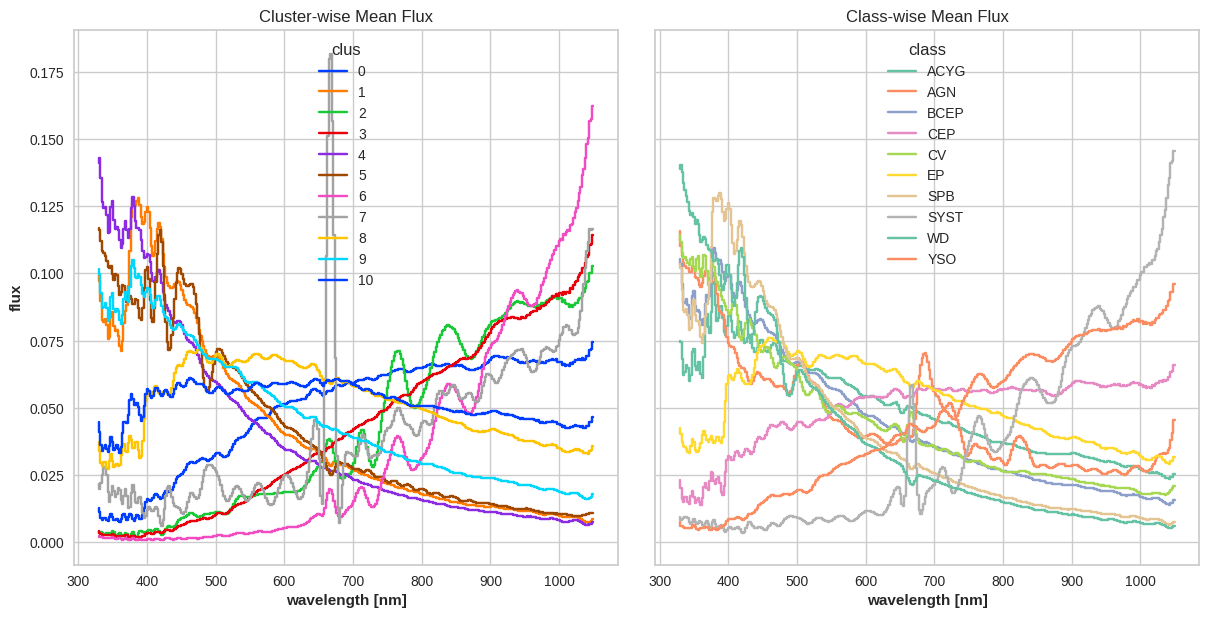

In [ ]:
## Compute & plot cluster-wise Mean Flux, compare to the (known) class-wise mean fluxes we computed from our labels
clus_mean_flux = flux.groupby(clus_myK).mean().reset_index(names="clus").melt(id_vars="clus", var_name="wavelength [nm]", value_name="flux")

plt.rcParams['figure.figsize'] = (12,6)
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.tight_layout()
sns.lineplot(x = 'wavelength [nm]', y = 'flux', data = clus_mean_flux, drawstyle='steps-pre', hue='clus', palette="bright", ax=axes[0]).set(title="Cluster-wise Mean Flux");
sns.lineplot(x = 'wvl', y = 'flux', data = class_mean_df, drawstyle='steps-pre', hue='class', palette="Set2", ax=axes[1]).set(title="Class-wise Mean Flux", xlabel='wavelength [nm]');
plt.show()

# Supervised Learning with Gaia

Previously, we have attempted to learn about Gaia with unsupervised learning techniques. Using only the source spectra, we have created 2-d visualizations of Gaia and determined, via both visual inspection and formal clustering, that there are likely some natural groupings within the data. These techniques are intended to help you explore high-dimensional data when you otherwise know nothing about it.

In some settings we are given **auxiliarly information** about our data (i.e., our labels), and are interested in building a model to **predict** this auxiliary info. about new (but similar) data that we may encounter in the future. This task is called Supervised Machine Learning. The "supervisor" is the auxiliary info we receive.



## Classification with Neural Networks  

Given a data vector $x$ (e.g., one of our spectra) and its associated label $y$ (e.g., the star type associated the spectra), Supervised Learning algorithms  try to find a function $f(x)$, which is called the *model*, such that $y = f(x)$ is satisfied for as many $x$ in our dataset as possible. Thus, Supervised Learning is learning the relationship between our data and its label.

When $y$ is a categorical label (which is our setting), the process of finding an optimal $f$ is called ***classification***; when $y$ is numeric, it is known as ***regression***.

As with clustering, there are [many different classification algorithms](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html). Today, we will fit a [Multi Layer Perceptron](https://scikit-learn.org/stable/modules/neural_networks_supervised.html), also called a neural network. A MLP is a network of artificial nodes (neurons), which are basically small processing units arranged in a user-specified way to connect information in the data to that in the labels.  The process of forming these connections between artificial neurons is called ***neural learning***, or *model fitting*.  The number of neurons, and how they are arranged in the network, are the major parameters a user can control to influence the success of neural learning. Different network architectures give rise to different models from which we must select the best. Generally, more neurons in the network allows better prediction accuracy, but at the cost of longer computational time, and the inability of the model to best generalize its predictions on new data. So, there is a tradeoff.

## Model Selection via Cross Validation

Once a model $f$ is fit, it can be used to make label predictions $y^* = f(x^*)$ on new (unseen) data $x^*$. In addition to predicting the label $y^*$ for new data, we are also interested in obtaining some idea of how right (or wrong) our predictions might be.  This is called ***uncertainty estimation***, and forms the basis for all statistics.

**K-Fold Cross validation** is one way of estimating this uncertainty. The "best" supervised learning model among a set of candidate models is then selected as the most accurate, when this uncertainty is incorporated.  Briefly, K-Fold CV involves:
1. Splitting our dataset into a training set and a test set.
2. The model is fit on the training data, and ...
3. used to predict the labels for the data in the test set.
4. We then measure the model's predictive accuracy on the test set, because we know the true labels associated with this set.  
5. This process is repeated $K$ times, and we infer uncertainty about predictions based on the range of accuracies we observe during the process.

Note that in each round of the above, the test data does not influence the model fitting process. This is what allows us to generalize how well our model performs in the real world.

## Building a Gaia Classifier

Let's specify two different network architectures to learn a predictive model for Gaia. One will be a MLP with 1 hidden layer of 100 neurons, and the other will be a MLP with a hidden layer of 10 neurons. The neurons which are doing the learning are called the network's ***hidden neurons***. We will perform 5-Fold Cross Validation in order to select between the two competing architectures.  

There is a lot going on here, but it is relatively easy to accomplish with just a few scikit-learn functions. *Note that the following cell may take a few minutes to run.*

In [ ]:
## Define model100, with 100 neurons in a single hidden layer
model100 = MLPClassifier(hidden_layer_sizes=100, verbose=False, warm_start=True, max_iter=500, tol = 1e-3)
## Define model10, with 10 neurons in a single hidden layer
model10 = MLPClassifier(hidden_layer_sizes=10, verbose=False, warm_start=True, max_iter=500, tol = 1e-3)

## scikit-learn's cross_val_predict function takes a model and a specified number K of CV folds,
## splits the whole dataset into train/test sets (folds) K different times.
## For each of the K folds, the model is fit on the train set, and labels are predicted for the test set.
## The output of cross_val_predict is a label vector, whose i-th component is the prediction made for observation i,
## when i was in the test set due to CV splitting.
CV_Folds = 5

np.random.seed(123)
pred_class_label10 = cross_val_predict(model10, X=flux, y=class_label, cv=CV_Folds, n_jobs=5, verbose=2, method='predict')
pred_class_label100 = cross_val_predict(model100, X=flux, y=class_label, cv=CV_Folds, n_jobs=5, verbose=2, method='predict')

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.2min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.5min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   28.3s remaining:   42.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   33.2s finished


**How do we assess how well our different models performed?**

A [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) helps identify where your models are working well, and where they are failing. Confusion matrices are tables whose $(i,j)$ entry contains the count of observations whose true label is $i$, but whose predicted label (by the model) is $j$. Often, these counts are normalized with respect to the total number of observations whose true label is $i$, such that the rowsums of the table = 1. Examining a confusion matrix immediately tells you which classes your classifier is having trouble predicting, if any. Given its special structure, ideally we want the diagonal entries of the matrix to = 1, and all off-diagonal entries = 0.

Let's compute and visualize a confusion matrix for the predictions we just made of the star types of Gaia sources with each model:

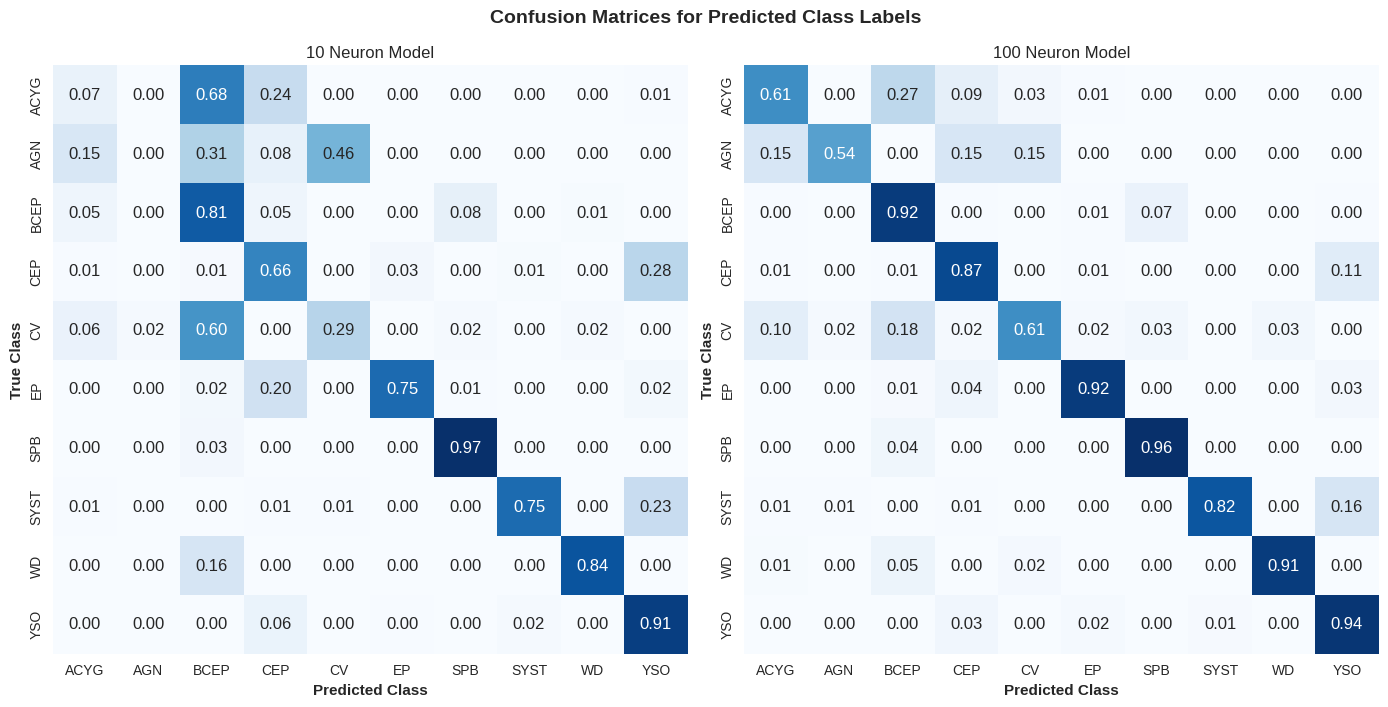

In [ ]:
# Make confusion matrices for each model, convert to data frame for plotting
cfmat10 = confusion_matrix(y_true = class_label, y_pred = pred_class_label10, normalize='true')
cfmat10 = pd.DataFrame(cfmat10, columns=np.unique(class_label), index=np.unique(class_label))

cfmat100 = confusion_matrix(y_true = class_label, y_pred = pred_class_label100, normalize='true')
cfmat100 = pd.DataFrame(cfmat100, columns=np.unique(class_label), index=np.unique(class_label))

# Visualize
plt.rcParams['figure.figsize'] = (14,7)
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False)
fig.tight_layout()
fig.suptitle("Confusion Matrices for Predicted Class Labels", fontsize=14)
sns.heatmap(cfmat10, cmap = 'Blues', annot=True, fmt='.2f', cbar=False, ax=axes[0]).set(title='10 Neuron Model', xlabel = 'Predicted Class', ylabel = 'True Class');
sns.heatmap(cfmat100, cmap = 'Blues', annot=True, fmt='.2f', cbar=False, ax=axes[1]).set(title='100 Neuron Model', xlabel = 'Predicted Class', ylabel = 'True Class');

fig.subplots_adjust(top=0.90)
plt.show()


**Based on these confusion matrices ...**

**Do you think the 10 neuron model is better/worse/the same than the 100 neuron model at generalizing its predictions to unseen data (the test set)?**

**Which class does each model predict well, and which class does each model predict poorly? Can you guess why? (hint ... look at the class-wise mean flux plots above)**

**Which neural network architecture would you use? Store your decisions in the variable best_arch below.**



In [ ]:
## Uncomment the line below that corresponds to the more accurate model
#best_arch = 100
#best_arch = 10

**Cross validation is performed solely for model selection purposes.** Once a  model has been selected via CV, we must re-fit it using all available data for training. This gives us the most informed model from which we can make predictions about new data in the future.  Below we re-fit, using the `best_arch` specified above.

In [ ]:
## Refit MLP with all data, using selected architecture
best_model = MLPClassifier(hidden_layer_sizes=best_arch, verbose=True, max_iter=500, tol = 1e-3)
best_model.fit(flux, class_label)

Iteration 1, loss = 2.04354578
Iteration 2, loss = 1.68639153
Iteration 3, loss = 1.47030386
Iteration 4, loss = 1.33089740
Iteration 5, loss = 1.23682022
Iteration 6, loss = 1.17320306
Iteration 7, loss = 1.12586569
Iteration 8, loss = 1.09006512
Iteration 9, loss = 1.05854313
Iteration 10, loss = 1.03222869
Iteration 11, loss = 1.00964510
Iteration 12, loss = 0.99094868
Iteration 13, loss = 0.97465363
Iteration 14, loss = 0.95850019
Iteration 15, loss = 0.94527077
Iteration 16, loss = 0.93228144
Iteration 17, loss = 0.91821341
Iteration 18, loss = 0.90788861
Iteration 19, loss = 0.89503429
Iteration 20, loss = 0.88380515
Iteration 21, loss = 0.87316511
Iteration 22, loss = 0.86014875
Iteration 23, loss = 0.85078079
Iteration 24, loss = 0.84115037
Iteration 25, loss = 0.82969750
Iteration 26, loss = 0.82034870
Iteration 27, loss = 0.81208352
Iteration 28, loss = 0.80402369
Iteration 29, loss = 0.79444077
Iteration 30, loss = 0.78702278
Iteration 31, loss = 0.77853638
Iteration 32, los

MLPClassifier(hidden_layer_sizes=100, max_iter=500, tol=0.001, verbose=True)

## Predicting Labels for New Gaia Sources

Breaking news! An update to the Gaia archive contains spectra for several new sources, and we are asked to predict the labels (type of star) for these new sources based on the classification model we just built. `scikit-learn` makes this relatively easy.

Let's fetch & inspect the new data.

In [ ]:
## Download & inspect new data
new_flux = pd.read_csv('https://raw.githubusercontent.com/jt-ut/GaiaREU/main/data/GaiaREU_flux_tst.csv', header=None)
new_flux.columns = wvl
print(new_flux.shape)
print(new_flux.iloc[0])

(593, 343)
0
330.000000     0.157631
332.105263     0.140994
334.210526     0.124082
336.315789     0.120104
338.421053     0.125592
                 ...   
1041.578947    0.004656
1043.684211    0.004211
1045.789474    0.004113
1047.894737    0.004181
1050.000000    0.004694
Name: 0, Length: 343, dtype: float64


With a previously fit model in hand, we can easily obtain the predicted labels for these new data

In [ ]:
## Predict class labels for new data using best_model
new_flux_predicted_label = best_model.predict(new_flux)
pd.Series(new_flux_predicted_label).value_counts()

YSO     202
CEP     105
BCEP     94
SPB      89
EP       30
SYST     28
ACYG     19
WD       15
CV       11
Name: count, dtype: int64

One simple way to check whether your predictions are good is to determine whether our newly predicted data for a given class look like our known data of that same class. Below, we will plot the spectral statistics for each of our training set classes, and the corresponding stats for these newly predicted classes, for comparison.

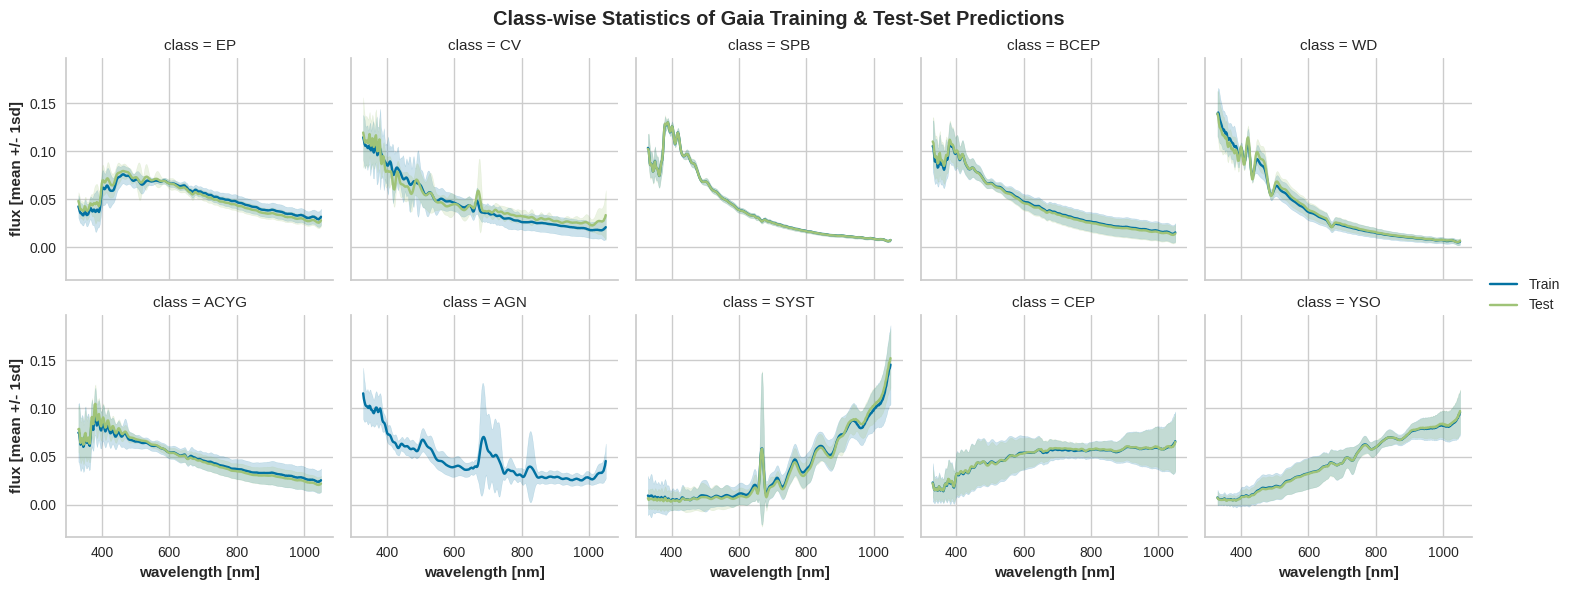

In [ ]:
## Reshape the new_flux data frame for plotting, add in the predicted class label by source
tmp = new_flux.reset_index(names='source').melt(id_vars='source',var_name="wvl", value_name="flux")
tmp['class'] = new_flux_predicted_label[tmp['source']]
tmp.drop(columns='source', inplace=True)
tmp.assign(set = "Test")

combinedf = pd.concat([class_stat_df.assign(set = "Train"), tmp.assign(set = "Test")])

# Seaborn Faceting makes group-wise summaries easy to visualize
plt_clstat = sns.FacetGrid(combinedf, col='class', col_wrap=5);
plt_clstat.map_dataframe(sns.lineplot, x="wvl", y="flux", errorbar=('sd',1), hue='set').set(ylabel = 'flux [mean +/- 1sd]', xlabel='wavelength [nm]');
plt_clstat.fig.subplots_adjust(top=0.9);
plt_clstat.fig.suptitle('Class-wise Statistics of Gaia Training & Test-Set Predictions');
plt_clstat.add_legend();


**Do the fluxes for the new sources seem to fit with the statistics for the known classes in the training set?**